In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# physio_path = "/content/drive/MyDrive/Colab Notebooks/FYP/data/Exp4/Exp4/Preprocessed/Physio/periods/features_segm_1.csv"
# driving_path = "/content/drive/MyDrive/Colab Notebooks/FYP/data/Exp4/Exp4/Preprocessed/Driving/features_tor_10s_30s_rows.csv"
# pvt_path = "/content/drive/MyDrive/Colab Notebooks/FYP/data/Exp4/Exp4/Preprocessed/PVT/data_PVT_no_outliers_mean_sd.csv"

In [3]:
pvt_path = "../Exp4/Preprocessed/PVT/data_PVT_no_outliers_mean_sd.csv"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv(pvt_path)

print(data.shape)

(63, 15)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   code             63 non-null     object 
 1   subject_id       63 non-null     int64  
 2   sleep_condition  63 non-null     int64  
 3   time_experiment  63 non-null     int64  
 4   first_scenario   63 non-null     object 
 5   RT_0_City        61 non-null     float64
 6   RT_1_City        60 non-null     float64
 7   RT_2_City        55 non-null     float64
 8   RT_3_City        53 non-null     float64
 9   RT_4_City        22 non-null     float64
 10  RT_0_Country     60 non-null     float64
 11  RT_1_Country     57 non-null     float64
 12  RT_2_Country     62 non-null     float64
 13  RT_3_Country     62 non-null     float64
 14  RT_4_Country     61 non-null     float64
dtypes: float64(10), int64(3), object(2)
memory usage: 7.5+ KB


In [6]:
data.head()

,code,subject_id,sleep_condition,time_experiment,first_scenario,RT_0_City,RT_1_City,RT_2_City,RT_3_City,RT_4_City,RT_0_Country,RT_1_Country,RT_2_Country,RT_3_Country,RT_4_Country
0,01_AC16,1,0,16,Country,1.081116,0.822021,1.106934,1.363037,NaN,1.299316,3.667419,2.049561,1.050903,0.699707
1,02_DU16,2,1,16,City,0.954437,2.314331,NaN,NaN,NaN,0.749969,1.362122,1.615845,NaN,1.899658
2,03_AC16,3,0,16,Country,1.022156,1.008484,1.222046,1.314209,0.899292,0.726898,1.000244,0.831909,1.666626,0.900024
3,04_DC16,4,1,16,Country,1.710815,1.583008,1.559570,1.510010,NaN,1.700867,NaN,1.499390,1.400513,1.433350
4,05_AC10,5,0,10,Country,1.815369,1.424805,NaN,NaN,NaN,1.666779,1.383423,1.466309,1.500610,1.433350


In [7]:
label_counts = data["sleep_condition"].value_counts()
print(label_counts)

sleep_condition
0    32
1    31
Name: count, dtype: int64


C:\Users\kahch\AppData\Local\Temp\ipykernel_67596\3141730654.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


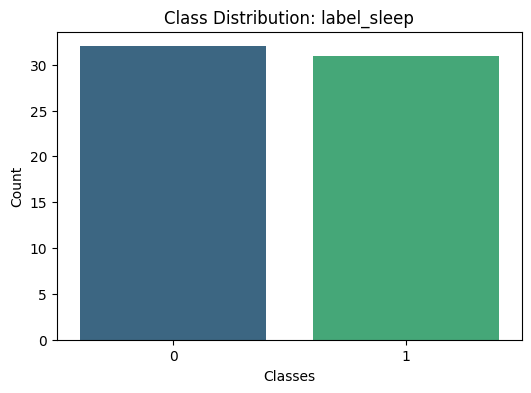

In [8]:
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Class Distribution: label_sleep")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()


In [ ]:
columns_to_drop = ["code"]
data = data.drop(columns=columns_to_drop, axis=1)

#Data Preprocessing

In [ ]:
columns_to_exclude = data.columns[data.isnull().mean() > 0.5]
data = data.drop(columns=columns_to_exclude)

data.replace([np.inf, -np.inf], np.nan, inplace=True)

numerical_data = data.select_dtypes(include=['number'])

missing_values = numerical_data.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

data.fillna(numerical_data.mean(), inplace=True)

missing_after = data.isnull().sum()
print("\nMissing Values After Filling:\n", missing_after[missing_after > 0])

if missing_after.sum() == 0:
    print("\nAll missing values have been successfully filled!")
else:
    print("\nThere are still missing values in the dataset.")

Missing Values:
 RT_0_City        2
RT_1_City        3
RT_2_City        8
RT_3_City       10
RT_0_Country     3
RT_1_Country     6
RT_2_Country     1
RT_3_Country     1
RT_4_Country     2
dtype: int64

Missing Values After Filling:
 Series([], dtype: int64)

All missing values have been successfully filled!


In [ ]:
data["first_scenario"] = data["first_scenario"].map({"Country": 0, "City": 1})

print("\n'label_first_scenario' Column After Encoding:\n", data["first_scenario"].head())


'label_first_scenario' Column After Encoding:
 0    0
1    1
2    0
3    0
4    0
Name: first_scenario, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data["sleep_condition"] = label_encoder.fit_transform(data["sleep_condition"])

print("Encoded Labels:\n", data["sleep_condition"].unique())

Encoded Labels:
 [0 1]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

X = data.drop(columns=["sleep_condition", "subject_id"]).values
y = data['sleep_condition'].values

encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Training Set Size: {x_train.shape}")
print(f"Testing Set Size: {x_test.shape}")

scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.transform(x_test)

Training Set Size: (50, 11)
Testing Set Size: (13, 11)


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

input_size = x_train_norm.shape[1]
output_size = y_train.shape[1]

embedding_dim = 32
input_embeddings = layers.Input(shape=(input_size,))
embeddings = layers.Embedding(input_dim=1000, output_dim=embedding_dim)(input_embeddings)

embeddings = layers.Reshape((input_size, embedding_dim))(embeddings)

self_attention = layers.MultiHeadAttention(num_heads=4, key_dim=embedding_dim)(embeddings, embeddings)
self_attention = layers.Dropout(0.1)(self_attention)
self_attention = layers.LayerNormalization(epsilon=1e-6)(self_attention + embeddings)

intersample_attention = layers.MultiHeadAttention(num_heads=4, key_dim=embedding_dim)(self_attention, self_attention)
intersample_attention = layers.Dropout(0.1)(intersample_attention)
intersample_attention = layers.LayerNormalization(epsilon=1e-6)(intersample_attention + self_attention)

flattened = layers.Flatten()(intersample_attention)
dense_1 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(flattened)
dropout_1 = layers.Dropout(0.5)(dense_1)
output = layers.Dense(output_size, activation='sigmoid')(dropout_1)

model = models.Model(inputs=input_embeddings, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    x_train_norm, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test_norm, y_test),
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

val_loss, val_accuracy = model.evaluate(x_test_norm, y_test, verbose=0)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

y_pred = model.predict(x_test_norm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 450ms/step - accuracy: 0.4392 - loss: 2.7537 - val_accuracy: 0.3846 - val_loss: 2.6550
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5267 - loss: 2.6157 - val_accuracy: 0.4615 - val_loss: 2.4994
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5133 - loss: 2.5687 - val_accuracy: 0.6154 - val_loss: 2.4337
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6054 - loss: 2.4399 - val_accuracy: 0.5385 - val_loss: 2.4150
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5371 - loss: 2.4056 - val_accuracy: 0.3846 - val_loss: 2.4339
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5533 - loss: 2.3491 - val_accuracy: 0.3846 - val_loss: 2.4086
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5504 - loss: 2.3236 - val_accuracy: 0.3846 - val_loss: 2.3239
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6454 - loss: 2.2094 - val_accuracy: 0.3846 - val_loss

In [15]:
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes))

accuracy = accuracy_score(y_true_classes, y_pred_classes)
if y_test.shape[1] == 2:
    roc_auc = roc_auc_score(y_true_classes, y_pred[:, 1])
else:
    roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='weighted')

precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.67      0.80      0.73         5

    accuracy                           0.77        13
   macro avg       0.76      0.78      0.76        13
weighted avg       0.78      0.77      0.77        13

Accuracy: 0.77
ROC-AUC Score: 0.76
Precision: 0.76
Recall: 0.78
F1-Score: 0.76


<Figure size 1000x800 with 0 Axes>

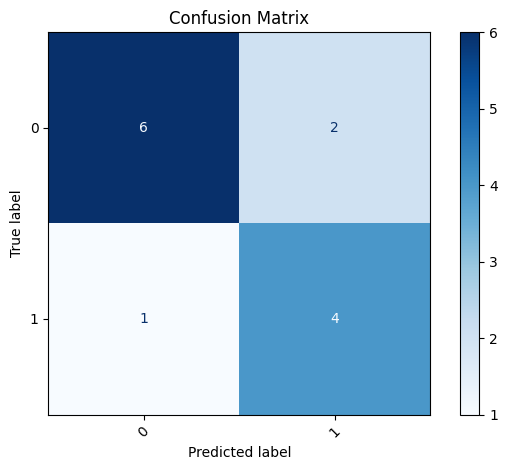

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
class_names = label_encoder.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

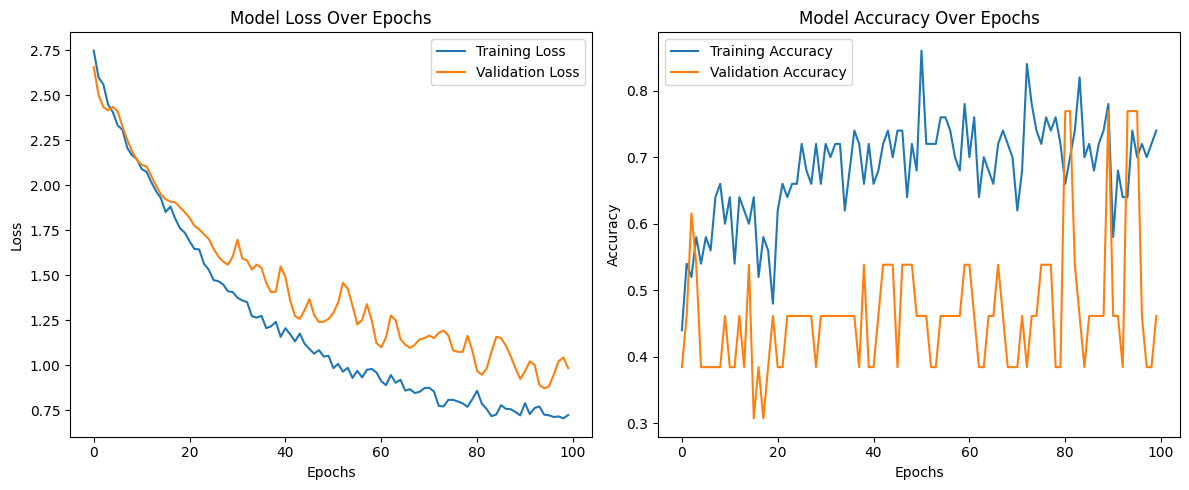

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

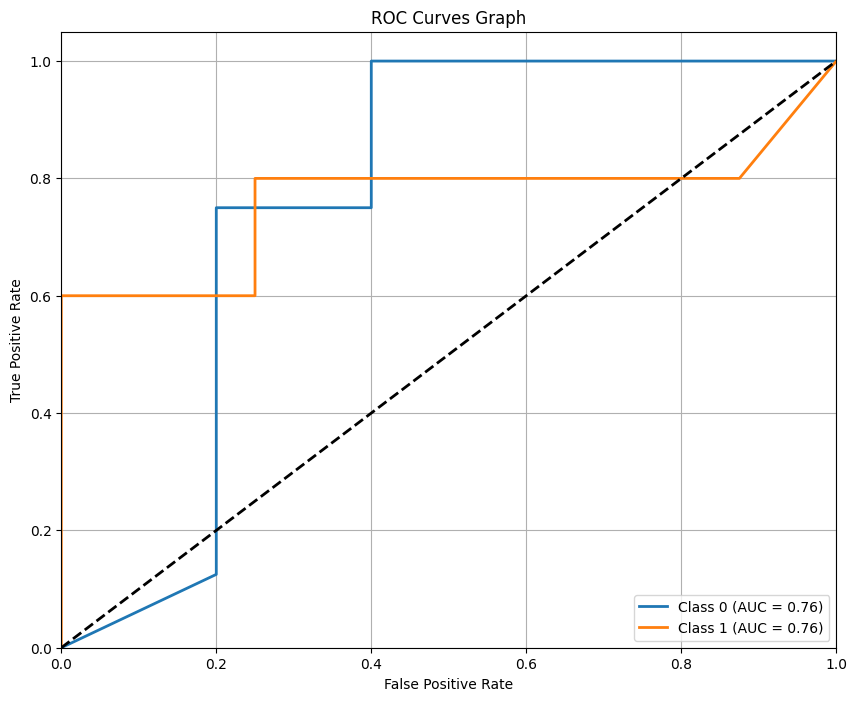

In [18]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, 
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Graph')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

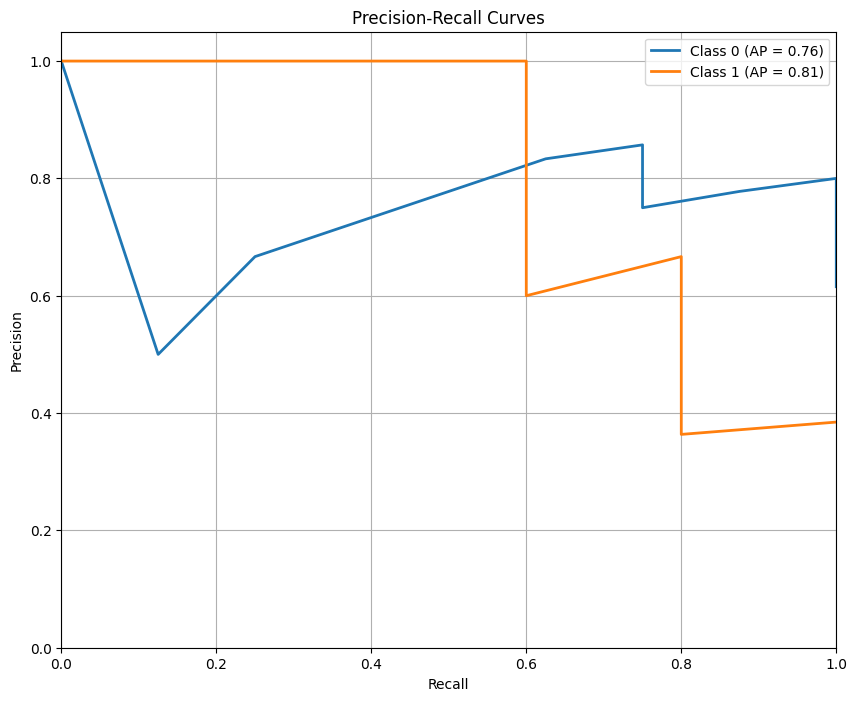

In [19]:
plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    avg_precision = average_precision_score(y_test[:, i], y_pred[:, i])
    plt.plot(recall, precision, lw=2,
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AP = {avg_precision:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [20]:
!pip install keras-tuner

In [ ]:
import keras_tuner as kt

def build_saint_model(hp):
    input_size = x_train_norm.shape[1]
    output_size = y_train.shape[1]

    embedding_dim = hp.Choice('embedding_dim', values=[16, 32, 64])
    input_embeddings = layers.Input(shape=(input_size,))
    embeddings = layers.Embedding(input_dim=1000, output_dim=embedding_dim)(input_embeddings)

    embeddings = layers.Reshape((input_size, embedding_dim))(embeddings)

    self_attention = layers.MultiHeadAttention(
        num_heads=hp.Choice('num_heads', values=[2, 4, 8]),
        key_dim=embedding_dim
    )(embeddings, embeddings)
    self_attention = layers.Dropout(hp.Choice('dropout_1', values=[0.1, 0.2, 0.3]))(self_attention)
    self_attention = layers.LayerNormalization(epsilon=1e-6)(self_attention + embeddings)

    intersample_attention = layers.MultiHeadAttention(
        num_heads=hp.Choice('num_heads', values=[2, 4, 8]),
        key_dim=embedding_dim
    )(self_attention, self_attention)
    intersample_attention = layers.Dropout(hp.Choice('dropout_2', values=[0.1, 0.2, 0.3]))(intersample_attention)
    intersample_attention = layers.LayerNormalization(epsilon=1e-6)(intersample_attention + self_attention)

    flattened = layers.Flatten()(intersample_attention)
    dense_1 = layers.Dense(
        units=hp.Choice('units_1', values=[64, 128, 256]),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01)
    )(flattened)
    dropout_1 = layers.Dropout(hp.Choice('dropout_3', values=[0.3, 0.4, 0.5]))(dense_1)
    output = layers.Dense(output_size, activation='sigmoid')(dropout_1)

    model = models.Model(inputs=input_embeddings, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.001, 0.005, 0.01])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner = kt.Hyperband(
    build_saint_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='SAINT_Tuning',
    project_name='SAINT_Hyperparameter_Tuning'
)

hyper_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(
    x_train_norm, y_train,
    validation_data=(x_test_norm, y_test),
    epochs=150,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[hyper_early_stopping],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"Number of Heads: {best_hps.get('num_heads')}")
print(f"Dropout in Self-Attention Block: {best_hps.get('dropout_1')}")
print(f"Dropout in Intersample Attention Block: {best_hps.get('dropout_2')}")
print(f"Units in Dense Layer: {best_hps.get('units_1')}")
print(f"Dropout in Dense Layer: {best_hps.get('dropout_3')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    x_train_norm, y_train,
    validation_data=(x_test_norm, y_test),
    epochs=150,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[hyper_early_stopping],
    verbose=1
)

y_pred_best = best_model.predict(x_test_norm)
y_pred_best_classes = np.argmax(y_pred_best, axis=1)
y_true_best_classes = np.argmax(y_test, axis=1)

Trial 90 Complete [00h 00m 33s]
val_accuracy: 0.692307710647583

Best val_accuracy So Far: 0.8461538553237915
Total elapsed time: 00h 17m 40s
Best Hyperparameters:
Embedding Dimension: 64
Number of Heads: 2
Dropout in Self-Attention Block: 0.3
Dropout in Intersample Attention Block: 0.3
Units in Dense Layer: 128
Dropout in Dense Layer: 0.5
Learning Rate: 0.001
Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 915ms/step - accuracy: 0.4050 - loss: 3.3534 - val_accuracy: 0.3846 - val_loss: 3.4539
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.4733 - loss: 3.2046 - val_accuracy: 0.6154 - val_loss: 2.8254
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5267 - loss: 2.9435 - val_accuracy: 0.6154 - val_loss: 2.7385
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5371 - loss: 2.8839 - val_accuracy: 0.3846 - val_loss: 2.7737
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step - accuracy: 0.5238 - loss: 2.7800 - val_accuracy: 0.3846 - val_loss: 2.7912
E

In [22]:
print("Classification Report:")
print(classification_report(y_true_best_classes, y_pred_best_classes))

accuracy = accuracy_score(y_true_best_classes, y_pred_best_classes)
roc_auc = roc_auc_score(y_test, y_pred_best, multi_class='ovr', average='weighted')
precision = precision_score(y_true_best_classes, y_pred_best_classes, average='macro')
recall = recall_score(y_true_best_classes, y_pred_best_classes, average='macro')
f1 = f1_score(y_true_best_classes, y_pred_best_classes, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.67      0.40      0.50         5

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13

Accuracy: 0.69
ROC-AUC Score: 0.51
Precision: 0.68
Recall: 0.64
F1-Score: 0.64


<Figure size 1000x800 with 0 Axes>

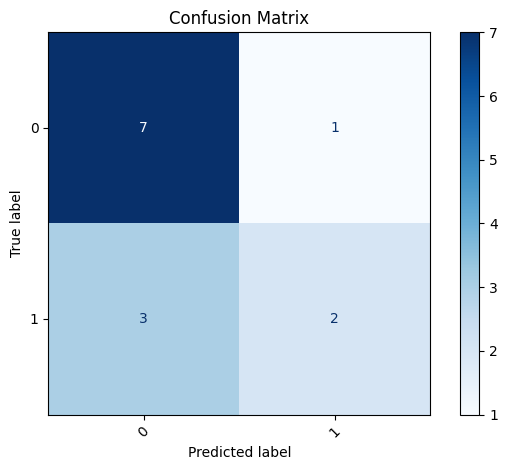

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_best_classes, y_pred_best_classes)

plt.figure(figsize=(10, 8))
class_names = label_encoder.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

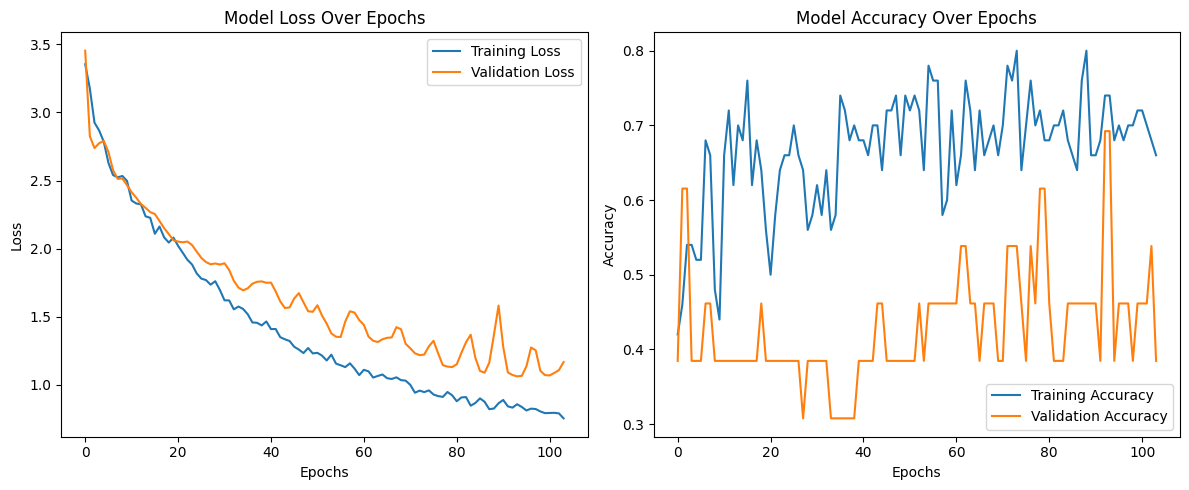

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

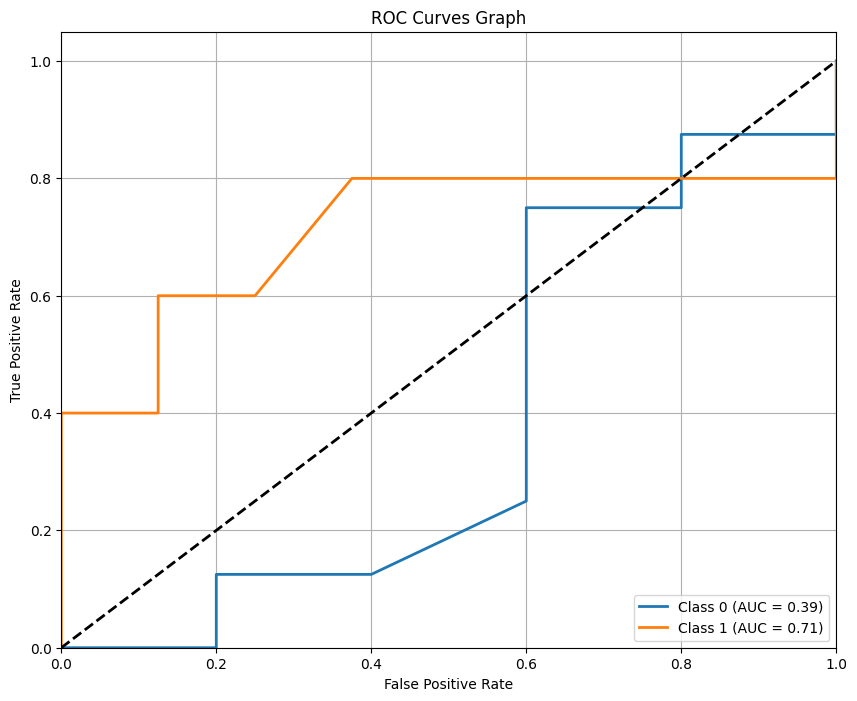

In [25]:
plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_best[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, 
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Graph')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

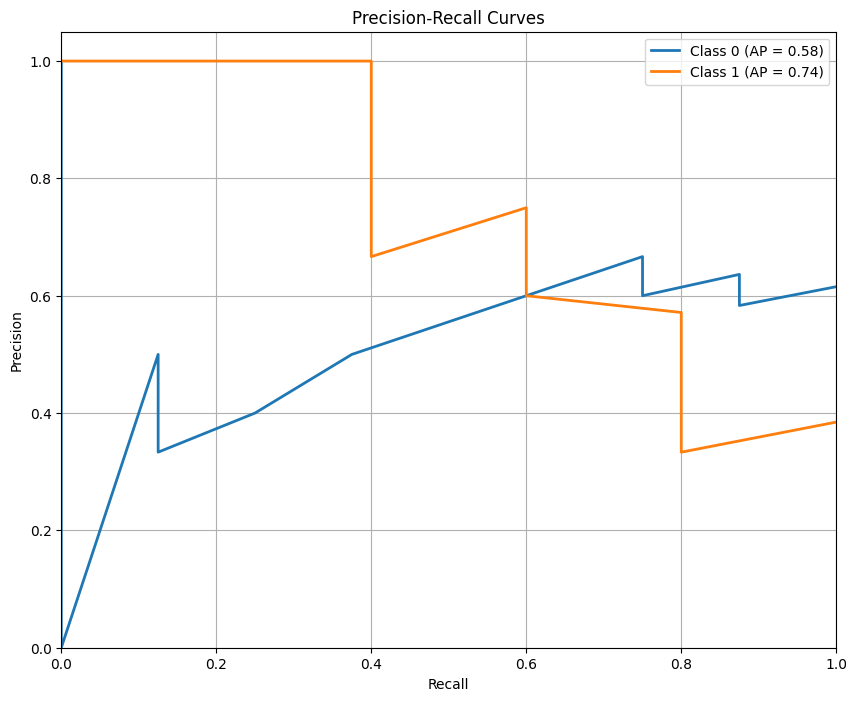

In [26]:
plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_best[:, i])
    avg_precision = average_precision_score(y_test[:, i], y_pred_best[:, i])
    plt.plot(recall, precision, lw=2,
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AP = {avg_precision:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 11, 32)    │     32,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 11, 32)    │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 11, 32)    │     16,800 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 11, 32)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 11, 32)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 11, 32)    │         64 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 11, 32)    │     16,800 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 11, 32)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 11, 32)    │          0 │ dropout_3[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 11, 32)    │         64 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 352)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     45,184 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        258 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 333,512 (1.27 MB)

 Trainable params: 111,170 (434.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 222,342 (868.53 KB)

In [28]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 11, 64)    │     64,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 11, 64)    │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 11, 64)    │     33,216 │ reshape_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 11, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 11, 64)    │          0 │ dropout_6[0][0],  │
│                     │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 11, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 11, 64)    │     33,216 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 11, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 11, 64)    │          0 │ dropout_8[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 11, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 704)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     90,240 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        258 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 663,560 (2.53 MB)

 Trainable params: 221,186 (864.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 442,374 (1.69 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


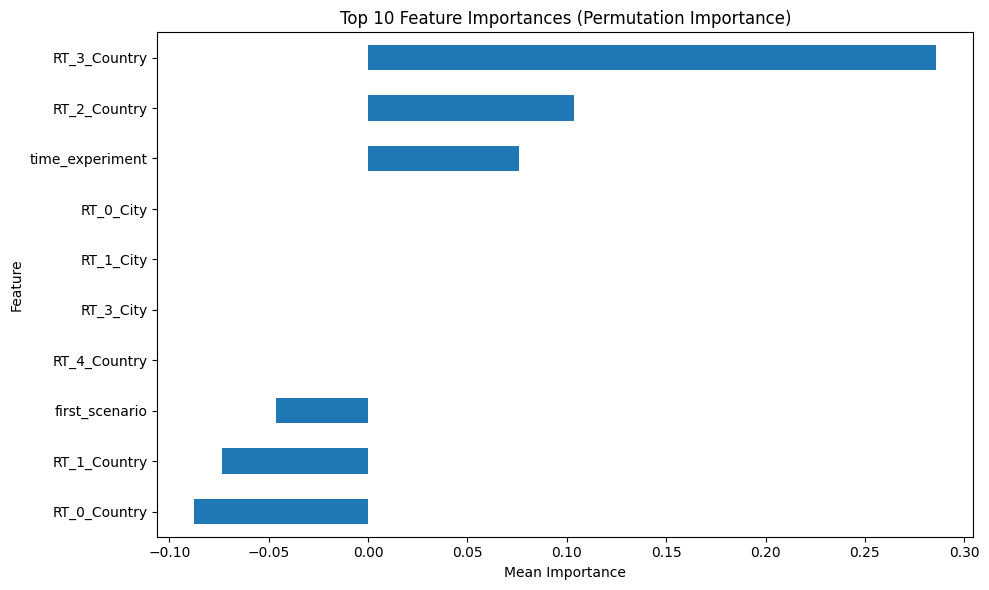

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']

perm_importance = permutation_importance(
    best_model,
    x_test_norm,
    y_test,
    scoring=scoring,
    n_repeats=1,
    random_state=42
)

feature_names = data.drop(columns=['subject_id', 'sleep_condition']).columns

feature_importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_importance['r2']['importances_mean']
}).sort_values(by="Importance", ascending=False)

feature_importances.head(10).plot(
    kind="barh",
    x="Feature",
    y="Importance",
    legend=False,
    figsize=(10, 6)
)
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Permutation Importance)")
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
